In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
import regex as re

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_data2(path,g=1,c=None,tf=None,train=1):
    d = pd.read_csv(path)
    d['Body_joined'] = d['Body']+d['Title']
    d['Body_joined'].apply(cleaning_text)
    d['Body_joined'].apply(rem_stop_words)
    if train == 1:
        c = CountVectorizer(ngram_range=(1,g))
        counts = c.fit_transform(d.Body_joined)
        tf = TfidfTransformer()
        d_tfidf = tf.fit_transform(counts)
    else:
        assert c != None
        assert tf != None
        counts = c.transform(d.Body_joined)
        d_tfidf = tf.transform(counts)
    return d_tfidf,c,tf,d['Y']

def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text

stop_words = set(stopwords.words('english'))
def rem_stop_words(words):
    l = [x for x in words.split(' ') if not x in stop_words]
    return ' '.join(l)

# Loading data - 1-gram

Loading data considering only single words as tokens.

In [ ]:
train_path = 'drive/MyDrive/EE769Project/train.csv'
test_path = 'drive/MyDrive/EE769Project/valid.csv'
d_train,c_train,tf_train,y_train = get_data2(train_path)
d_test,c_train,tf_train,y_test = get_data2(test_path,c=c_train,tf=tf_train,train=0)

print(d_train.shape)
print(d_test.shape)

new_values = {'HQ':2, 'LQ_EDIT':1, 'LQ_CLOSE':0}
y_train  = y_train.replace(new_values)
y_test = y_test.replace(new_values)

print(y_train.shape)
print(y_test.shape)

(45000, 204728)
(15000, 204728)
(45000,)
(15000,)


In [ ]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]

# Model Training and Testing

In [ ]:
clf_dict = {
    'LogisticRegression': LogisticRegression(),
    'SGDClassifier': SGDClassifier(),
    'LinearSVC': LinearSVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}

def do_gridSearch(clf,d_train,y_train,d_test,y_test,hyperparams):
    opt = GridSearchCV(clf, cv=5, param_grid=hyperparams,  scoring='f1_weighted', verbose=2.1)
    opt.fit(d_train, np.squeeze(y_train))
    print('Best parameters:')
    print(opt.best_params_)
    scoring='f1_weighted'
    print('Best' + scoring + ":" + str(opt.best_score_))
    print('Train classification report:')
    y_true, y_pred = np.squeeze(y_train), opt.predict(d_train)
    print(classification_report(y_true, y_pred))
    print('Test classification report:')
    y_true, y_pred = np.squeeze(y_test), opt.predict(d_test)
    print(classification_report(y_true, y_pred))
    return opt

In [ ]:
result_dict = {}
model_order = ['LogisticRegression','LinearSVC','RandomForestClassifier','GradientBoostingClassifier']
for clf_str in model_order:
    if clf_str == 'LogisticRegression':
        params = {'C':[0.01,0.1,1.0,10.0,100.0],'max_iter':[50,150,300,600],'multi_class':['auto']}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': [50,200,600],
                  'max_depth': [10,15,20]}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': [50,200,600],
                  'learning_rate': [0.01,0.1,0.5]}
    elif clf_str == 'LinearSVC':
        params = {'C':[0.01,0.1,1.0,10.0,100.0]}
    elif clf_str == 'SGDClassifier':
        params = {'loss':['hinge'],'alpha':[0.0001,0.001,0.01],'penalty':['elasticnet'],'l1_ratio':[0,0.2,0.7,1.0]}
    clf_fn = clf_dict[clf_str]
    print(" ")
    print("##########################################################################################################")
    print("Now doing",clf_str)
    opt = do_gridSearch(clf_fn,d_train,y_train,d_test,y_test,params)
    result_dict[clf_str] = opt

 
##########################################################################################################
Now doing LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.682, total=   6.8s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.688, total=   6.7s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.700, total=   5.7s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................
[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.702, total=   5.7s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................
[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.692, total=   6.3s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.682, total=   6.9s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.688, total=   6.8s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.700, total=   5.6s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.702, total=   5.8s
[CV] C=0.01, max_iter=150, multi_class=auto ......................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.787, total=  11.3s
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.783, total=  12.3s
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.780, total=  11.6s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.770, total=   9.7s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.776, total=  11.9s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.787, total=  15.9s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.783, total=  14.4s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.780, total=  17.5s
[CV] C=0.1, max_iter=300, multi_class=auto ...........................
[CV]  C=0.1, max_iter=300, multi_class=auto, score=0.770, total=   9.3s
[CV] C=0.1, max_iter=300, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.808, total=  11.0s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.812, total=  10.8s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.822, total=  11.0s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.821, total=  11.5s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.816, total=  11.1s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.809, total=  36.0s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.813, total=  32.4s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.822, total=  31.8s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.822, total=  32.9s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.819, total=  33.3s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.809, total=  44.5s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.813, total=  44.2s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.822, total=  43.8s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.822, total=  46.6s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.818, total=  46.0s
[CV] C=1.0, max_iter=600, multi_class=auto ...........................
[CV]  C=1.0, max_iter=600, multi_class=auto, score=0.809, total=  46.0s
[CV] C=1.0, max_iter=600, multi_class=auto ...........................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.805, total=  12.6s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.822, total=  11.8s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.818, total=  11.3s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.822, total=  10.9s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.817, total=  11.5s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.804, total=  33.1s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.814, total=  34.6s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.821, total=  34.0s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.820, total=  33.4s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.815, total=  33.0s
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.802, total= 1.1min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.814, total= 1.1min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.820, total= 1.1min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.820, total= 1.1min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.815, total= 1.1min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.802, total= 1.8min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.814, total= 1.7min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.819, total= 1.8min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.820, total= 1.8min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.815, total= 1.5min
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.804, total=  11.0s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.817, total=  11.2s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.817, total=  11.4s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.820, total=  11.1s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.819, total=  11.0s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.797, total=  33.3s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.808, total=  33.2s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.812, total=  33.7s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.814, total=  32.4s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.804, total=  33.0s
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.787, total= 1.1min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.801, total= 1.1min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.806, total= 1.1min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.802, total= 1.1min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.799, total= 1.1min
[CV] C=100.0, max_iter=600, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.787, total= 2.3min
[CV] C=100.0, max_iter=600, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.798, total= 2.2min
[CV] C=100.0, max_iter=600, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.806, total= 2.2min
[CV] C=100.0, max_iter=600, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.803, total= 2.2min
[CV] C=100.0, max_iter=600, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 55.9min finished


[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.796, total= 2.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best parameters:
{'C': 1.0, 'max_iter': 150, 'multi_class': 'auto'}
Bestf1_weighted:0.816953205496786
Train classification report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     15000
           1       0.89      0.94      0.91     15000
           2       0.92      0.91      0.92     15000

    accuracy                           0.90     45000
   macro avg       0.90      0.90      0.90     45000
weighted avg       0.90      0.90      0.90     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      5000
           1       0.82      0.88      0.85      5000
           2       0.86      0.86      0.86      5000

    accuracy                           0.83     15000
   macro avg       0.82      0.83      0.82     15000
weighted avg       0.82      0.83      0.82     15000

 
#############################################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.743, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.746, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.759, total=   1.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.754, total=   1.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.743, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.802, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.808, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.817, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.811, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............................. C=100.0, score=0.745, total=  31.6s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.756, total=  31.3s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.766, total=  31.2s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.750, total=  31.7s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.752, total=  31.6s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  4.3min finished


Best parameters:
{'C': 1.0}
Bestf1_weighted:0.8106657352896447
Train classification report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     15000
           1       0.96      0.97      0.97     15000
           2       0.97      0.97      0.97     15000

    accuracy                           0.96     45000
   macro avg       0.96      0.96      0.96     45000
weighted avg       0.96      0.96      0.96     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      5000
           1       0.83      0.85      0.84      5000
           2       0.85      0.86      0.86      5000

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000

 
##########################################################################################################
Now doing

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=10, n_estimators=50, score=0.673, total=   6.7s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.669, total=   6.6s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.694, total=   6.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.713, total=   6.7s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.711, total=   6.5s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.699, total=  25.9s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.701, total=  25.8s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.728, total=  26.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.723, total=  26.2s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 47.7min finished


Best parameters:
{'max_depth': 20, 'n_estimators': 600}
Bestf1_weighted:0.7476725012677508
Train classification report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     15000
           1       0.80      0.97      0.88     15000
           2       0.91      0.82      0.86     15000

    accuracy                           0.85     45000
   macro avg       0.86      0.85      0.85     45000
weighted avg       0.86      0.85      0.85     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67      5000
           1       0.74      0.88      0.80      5000
           2       0.79      0.77      0.78      5000

    accuracy                           0.75     15000
   macro avg       0.76      0.75      0.75     15000
weighted avg       0.76      0.75      0.75     15000

 
########################################################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

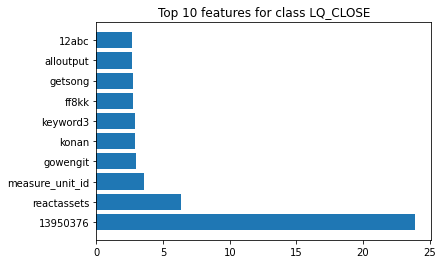

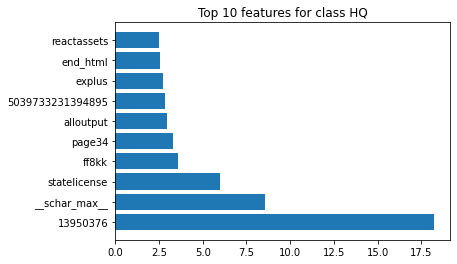

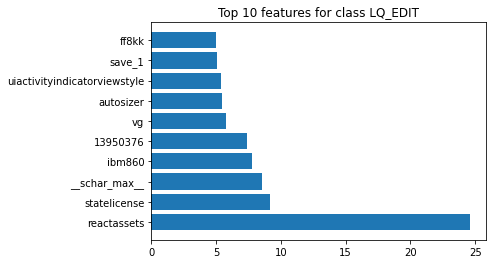

In [ ]:
model = LinearSVC(C=1.0)
model.fit(d_train,y_train)
def f_importances(coef, names, top_n, label):
    imp,names = zip(*sorted(zip(coef,names),reverse=True))
    plt.barh(range(top_n), imp[:top_n], align='center')
    plt.yticks(range(top_n), names[:top_n])
    plt.title("Top 10 features for class "+label)
    plt.show()
    

features_names = c_train.vocabulary_.keys()
class_name = 2
f_importances(abs(model.coef_[0]), features_names, top_n=10, label="LQ_CLOSE")
f_importances(abs(model.coef_[2]), features_names, top_n=10, label="HQ")
f_importances(abs(model.coef_[1]), features_names, top_n=10, label="LQ_EDIT")

In [ ]:
features_names = c_train.vocabulary_
print(type(features_names))

<class 'dict'>


In [ ]:
model_order = ['SGDClassifier']
for clf_str in model_order:
    if clf_str == 'LogisticRegression':
        params = {'C':[0.01,0.1,1.0,10.0,100.0],'max_iter':[50,150,300,600],'multi_class':['auto']}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': [50,200,600],
                  'max_depth': [10,15,20]}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': [50,200,600],
                  'learning_rate': [0.01,0.1,0.5]}
    elif clf_str == 'LinearSVC':
        params = {'C':[0.01,0.1,1.0,10.0,100.0]}
    elif clf_str == 'SGDClassifier':
        params = {'loss':['hinge'],'alpha':[0.0001,0.001,0.01],'penalty':['elasticnet'],'l1_ratio':[0,0.2,0.7,1.0]}
    clf_fn = clf_dict[clf_str]
    print(" ")
    print("##########################################################################################################")
    print("Now doing",clf_str)
    opt = do_gridSearch(clf_fn,d_train,y_train,d_test,y_test,params)
    result_dict[clf_str] = opt

 
##########################################################################################################
Now doing SGDClassifier
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.795, total=   2.2s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.797, total=   2.3s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.809, total=   2.2s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........
[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.801, total=   2.3s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........
[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.797, total=   2.3s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.791, total=   2.0s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.796, total=   2.1s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.807, total=   2.0s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.4min finished


Best parameters:
{'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'hinge', 'penalty': 'elasticnet'}
Bestf1_weighted:0.8025481835872419
Train classification report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74     15000
           1       0.79      0.93      0.86     15000
           2       0.84      0.85      0.84     15000

    accuracy                           0.82     45000
   macro avg       0.82      0.82      0.81     45000
weighted avg       0.82      0.82      0.81     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.73      5000
           1       0.80      0.91      0.85      5000
           2       0.82      0.84      0.83      5000

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000



In [ ]:
best_params = {}
best_params['SGDClassifier'] = {'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'hinge', 'penalty': 'elasticnet'}
best_params['RandomForestClassifier'] = {'max_depth': 20, 'n_estimators': 600}
best_params['LinearSVC'] = {'C': 1.0}
best_params['LogisticRegression'] = {'C': 1.0, 'max_iter': 150, 'multi_class': 'auto'}

In [ ]:
rf = RandomForestClassifier('max_depth': 20, 'n_estimators': 600)
rf.fit(d_train,y_train)
feat_imp = rf.feature_importances_
s = np.argsort(feat_imp)

# Loading data - 2-gram
 

In [ ]:
train_path = 'drive/MyDrive/EE769Project/train.csv'
test_path = 'drive/MyDrive/EE769Project/valid.csv'
d_train2,c_train2,tf_train2,y_train2 = get_data2(train_path,g=2)
d_test2,c_train2,tf_train2,y_test2 = get_data2(test_path,g=2,c=c_train2,tf=tf_train2,train=0)

print(d_train2.shape)
print(d_test2.shape)

new_values = {'HQ':2, 'LQ_EDIT':1, 'LQ_CLOSE':0}
y_train2  = y_train2.replace(new_values)
y_test2 = y_test2.replace(new_values)

print(y_train2.shape)
print(y_test2.shape)

(45000, 1825724)
(15000, 1825724)
(45000,)
(15000,)


# Model Training and Testing

In [ ]:
result_dict2 = {}
model_order = ['LogisticRegression','LinearSVC','RandomForestClassifier','SGDClassifier','GradientBoostingClassifier']
for clf_str in model_order:
    if clf_str == 'LogisticRegression':
        params = {'C':[0.01,0.1,1.0,10.0,100.0],'max_iter':[50,150,300,600],'multi_class':['auto']}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': [50,200,600],
                  'max_depth': [10,15,20]}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': [50,200,600],
                  'learning_rate': [0.01,0.1,0.5]}
    elif clf_str == 'LinearSVC':
        params = {'C':[0.01,0.1,1.0,10.0,100.0]}
    elif clf_str == 'SGDClassifier':
        params = {'loss':['hinge'],'alpha':[0.0001,0.001,0.01],'penalty':['elasticnet'],'l1_ratio':[0,0.2,0.7,1.0]}
    clf_fn = clf_dict[clf_str]
    print(" ")
    print("##########################################################################################################")
    print("Now doing",clf_str)
    opt = do_gridSearch(clf_fn,d_train2,y_train2,d_test2,y_test2,params)
    result_dict2[clf_str] = opt

 
##########################################################################################################
Now doing LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.669, total=  27.6s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.673, total=  27.7s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.3s remaining:    0.0s


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.688, total=  28.5s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................
[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.692, total=  27.8s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................
[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.685, total=  32.5s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.669, total=  26.7s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.673, total=  27.6s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.688, total=  28.2s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.692, total=  27.5s
[CV] C=0.01, max_iter=150, multi_class=auto ......................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.756, total= 1.1min
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.768, total= 1.1min
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.782, total= 1.1min
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.781, total= 1.1min
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.779, total= 1.1min
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.756, total= 1.2min
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.768, total= 1.6min
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.781, total= 1.5min
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.781, total= 1.4min
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.779, total= 1.4min
[CV] C=0.1, max_iter=300, multi_class=auto ...........................
[CV]  C=0.1, max_iter=300, multi_class=auto, score=0.756, total= 1.1min
[CV] C=0.1, max_iter=300, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.814, total= 1.1min
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.817, total= 1.1min
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.826, total= 1.1min
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.827, total= 1.1min
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.823, total= 1.1min
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.813, total= 3.2min
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.818, total= 3.2min
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.828, total= 3.3min
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.826, total= 3.2min
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.822, total= 3.2min
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.813, total= 3.4min
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.818, total= 3.5min
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.828, total= 3.3min
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.826, total= 3.4min
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.822, total= 3.7min
[CV] C=1.0, max_iter=600, multi_class=auto ...........................
[CV]  C=1.0, max_iter=600, multi_class=auto, score=0.813, total= 3.3min
[CV] C=1.0, max_iter=600, multi_class=auto ...........................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.818, total= 1.1min
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.828, total= 1.1min
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.841, total= 1.1min
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.836, total= 1.1min
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.835, total= 1.1min
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.824, total= 3.2min
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.829, total= 3.2min
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.838, total= 3.1min
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.835, total= 3.2min
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.830, total= 3.2min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.823, total= 6.4min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.829, total= 6.4min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.838, total= 6.3min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.836, total= 6.3min
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.831, total= 6.3min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.823, total= 8.1min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.829, total= 8.1min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.837, total= 7.8min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.836, total= 8.0min
[CV] C=10.0, max_iter=600, multi_class=auto ..........................
[CV]  C=10.0, max_iter=600, multi_class=auto, score=0.830, total= 9.2min
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.824, total= 1.2min
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.825, total= 1.2min
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.835, total= 1.2min
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.829, total= 1.1min
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.830, total= 1.1min
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.828, total= 3.4min
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.832, total= 3.4min
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.841, total= 3.4min
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.840, total= 3.3min
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.833, total= 3.2min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.825, total= 6.5min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.831, total= 6.5min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.840, total= 6.3min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.837, total= 6.3min
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.829, total= 6.3min
[CV] C=100.0, max_iter=600, multi_class=auto .........................
[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.825, total=12.0min
[CV] C=100.0, max_iter=600, multi_class=auto .........................
[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.831, total=11.8min
[CV] C=100.0, max_iter=600, multi_class=auto .........................
[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.839, total=11.6min
[CV] C=100.0, max_iter=600, multi_class=auto .........................
[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.837, total=10.7min
[CV] C=100.0, max_iter=600, multi_class=auto .........................
[CV]  C=100.0, max_iter=600, multi_class=auto, score=0.829, total=11.5min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 298.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best parameters:
{'C': 100.0, 'max_iter': 150, 'multi_class': 'auto'}
Bestf1_weighted:0.8346563969472154
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000
           2       1.00      1.00      1.00     15000

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      5000
           1       0.85      0.88      0.86      5000
           2       0.86      0.88      0.87      5000

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000

 
##########################################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.723, total=   3.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.730, total=   3.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.746, total=   2.9s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.746, total=   3.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.735, total=   2.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.802, total=   2.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.810, total=   2.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.820, total=   2.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.813, total=   2.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 11.2min finished


Best parameters:
{'C': 1.0}
Bestf1_weighted:0.8289946525136129
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000
           2       1.00      1.00      1.00     15000

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      5000
           1       0.85      0.87      0.86      5000
           2       0.86      0.88      0.87      5000

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000

 
##########################################################################################################
Now doing

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=10, n_estimators=50, score=0.670, total=  17.4s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.627, total=  17.5s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.9s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.658, total=  17.6s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.680, total=  17.6s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.720, total=  17.3s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.697, total= 1.1min
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.708, total= 1.2min
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.710, total= 1.1min
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.735, total= 1.1min
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

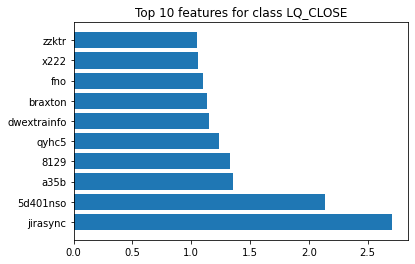

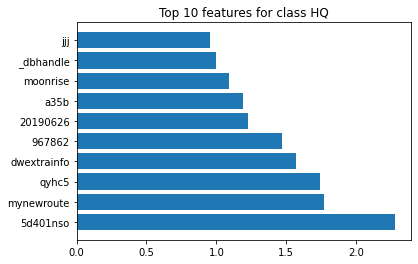

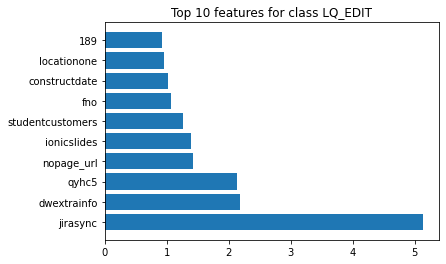

In [ ]:
model = LinearSVC(C=1.0)
model.fit(d_train2,y_train2)
def f_importances(coef, names, top_n, label):
    imp,names = zip(*sorted(zip(coef,names),reverse=True))
    plt.barh(range(top_n), imp[:top_n], align='center')
    plt.yticks(range(top_n), names[:top_n])
    plt.title("Top 10 features for class "+label)
    plt.show()
    

features_names = c_train.vocabulary_.keys()
class_name = 2
f_importances(abs(model.coef_[0]), features_names, top_n=10, label="LQ_CLOSE")
f_importances(abs(model.coef_[2]), features_names, top_n=10, label="HQ")
f_importances(abs(model.coef_[1]), features_names, top_n=10, label="LQ_EDIT")

The plots above show top 10 features with maximum importance for each class. X-axis shows the absolute value of their coefficient in the respective model.

In [ ]:
result_dict2 = {}
model_order = ['RandomForestClassifier','SGDClassifier','GradientBoostingClassifier']
for clf_str in model_order:
    if clf_str == 'LogisticRegression':
        params = {'C':[0.01,0.1,1.0,10.0,100.0],'max_iter':[50,150,300,600],'multi_class':['auto']}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': [50,200,600],
                  'max_depth': [10,15,20]}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': [50,200,600],
                  'learning_rate': [0.01,0.1,0.5]}
    elif clf_str == 'LinearSVC':
        params = {'C':[0.01,0.1,1.0,10.0,100.0]}
    elif clf_str == 'SGDClassifier':
        params = {'loss':['hinge'],'alpha':[0.0001,0.001,0.01],'penalty':['elasticnet'],'l1_ratio':[0,0.2,0.7,1.0]}
    clf_fn = clf_dict[clf_str]
    print(" ")
    print("##########################################################################################################")
    print("Now doing",clf_str)
    opt = do_gridSearch(clf_fn,d_train2,y_train2,d_test2,y_test2,params)
    result_dict2[clf_str] = opt

 
##########################################################################################################
Now doing RandomForestClassifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=10, n_estimators=50, score=0.688, total=  15.9s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.640, total=  15.3s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.1s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.642, total=  15.6s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.709, total=  15.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.677, total=  15.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.693, total=  58.9s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.714, total=  58.7s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.725, total=  59.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.738, total= 1.0min
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 101.2min finished


Best parameters:
{'max_depth': 20, 'n_estimators': 600}
Bestf1_weighted:0.7396654995440946
Train classification report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.75     15000
           1       0.71      0.99      0.83     15000
           2       0.91      0.81      0.86     15000

    accuracy                           0.81     45000
   macro avg       0.84      0.81      0.81     45000
weighted avg       0.84      0.81      0.81     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.82      0.54      0.65      5000
           1       0.68      0.95      0.79      5000
           2       0.82      0.77      0.79      5000

    accuracy                           0.75     15000
   macro avg       0.77      0.75      0.75     15000
weighted avg       0.77      0.75      0.75     15000

 
########################################################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.790, total=   5.5s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.795, total=   5.2s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.806, total=   5.5s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........
[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.798, total=   5.3s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........
[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.796, total=   5.6s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.770, total=   3.7s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.781, total=   4.2s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.794, total=   4.4s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.2min finished


Best parameters:
{'alpha': 0.0001, 'l1_ratio': 0, 'loss': 'hinge', 'penalty': 'elasticnet'}
Bestf1_weighted:0.797001735322447
Train classification report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82     15000
           1       0.82      0.97      0.89     15000
           2       0.90      0.93      0.92     15000

    accuracy                           0.88     45000
   macro avg       0.89      0.88      0.88     45000
weighted avg       0.89      0.88      0.88     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.84      0.64      0.73      5000
           1       0.78      0.92      0.85      5000
           2       0.83      0.88      0.85      5000

    accuracy                           0.81     15000
   macro avg       0.82      0.81      0.81     15000
weighted avg       0.82      0.81      0.81     15000

 
#####################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


# TFIDF with 10000 max features

In [ ]:
def get_data2_maxfeats(path,g=1,c=None,tf=None,train=1):
    d = pd.read_csv(path)
    d['Body_joined'] = d['Body']+d['Title']
    d['Body_joined'].apply(cleaning_text)
    d['Body_joined'].apply(rem_stop_words)
    if train == 1:
        c = CountVectorizer(ngram_range=(1,g),max_features=10000)
        counts = c.fit_transform(d.Body_joined)
        tf = TfidfTransformer()
        d_tfidf = tf.fit_transform(counts)
    else:
        assert c != None
        assert tf != None
        counts = c.transform(d.Body_joined)
        d_tfidf = tf.transform(counts)
    return d_tfidf,c,tf,d['Y']

def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text

stop_words = set(stopwords.words('english'))
def rem_stop_words(words):
    l = [x for x in words.split(' ') if not x in stop_words]
    return ' '.join(l)

In [ ]:
train_path = 'drive/MyDrive/EE769Project/train.csv'
test_path = 'drive/MyDrive/EE769Project/valid.csv'
d_train3,c_train3,tf_train3,y_train3 = get_data2_maxfeats(train_path)
d_test3,c_train3,tf_train3,y_test3 = get_data2_maxfeats(test_path,c=c_train3,tf=tf_train3,train=0)

print(d_train3.shape)
print(d_test3.shape)

new_values = {'HQ':2, 'LQ_EDIT':1, 'LQ_CLOSE':0}
y_train3  = y_train3.replace(new_values)
y_test3 = y_test3.replace(new_values)

print(y_train3.shape)
print(y_test3.shape)

(45000, 10000)
(15000, 10000)
(45000,)
(15000,)


In [ ]:
clf_dict = {
    'LogisticRegression': LogisticRegression(),
    'SGDClassifier': SGDClassifier(),
    'LinearSVC': LinearSVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
}

In [ ]:
result_dict3 = {}
model_order = ['LogisticRegression','LinearSVC','RandomForestClassifier','SGDClassifier','GradientBoostingClassifier']
for clf_str in model_order:
    if clf_str == 'LogisticRegression':
        params = {'C':[0.01,0.1,1.0,10.0,100.0],'max_iter':[50,150,300],'multi_class':['auto']}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': [50,200,600],
                  'max_depth': [10,15,20]}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': [50,200,600],
                  'learning_rate': [0.01,0.1,0.5]}
    elif clf_str == 'LinearSVC':
        params = {'C':[0.01,0.1,1.0,10.0,100.0]}
    elif clf_str == 'SGDClassifier':
        params = {'loss':['hinge'],'alpha':[0.0001,0.001,0.01],'penalty':['elasticnet'],'l1_ratio':[0,0.2,0.7,1.0]}
    clf_fn = clf_dict[clf_str]
    print(" ")
    print("##########################################################################################################")
    print("Now doing",clf_str)
    opt = do_gridSearch(clf_fn,d_train3,y_train3,d_test3,y_test3,params)
    result_dict3[clf_str] = opt

 
##########################################################################################################
Now doing LogisticRegression
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.691, total=   2.2s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.702, total=   2.3s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.711, total=   2.1s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................
[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.716, total=   2.0s
[CV] C=0.01, max_iter=50, multi_class=auto ...........................
[CV]  C=0.01, max_iter=50, multi_class=auto, score=0.707, total=   3.0s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.691, total=   2.2s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.702, total=   2.3s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.711, total=   2.3s
[CV] C=0.01, max_iter=150, multi_class=auto ..........................
[CV]  C=0.01, max_iter=150, multi_class=auto, score=0.716, total=   1.9s
[CV] C=0.01, max_iter=150, multi_class=auto ......................

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.779, total=   4.8s
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.783, total=   4.6s
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.794, total=   5.2s
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.793, total=   4.8s
[CV] C=0.1, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=0.1, max_iter=50, multi_class=auto, score=0.790, total=   4.9s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.779, total=   7.0s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.782, total=   6.7s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.795, total=   7.8s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.792, total=   7.4s
[CV] C=0.1, max_iter=150, multi_class=auto ...........................
[CV]  C=0.1, max_iter=150, multi_class=auto, score=0.790, total=   7.6s
[CV] C=0.1, max_iter=300, multi_class=auto ...........................
[CV]  C=0.1, max_iter=300, multi_class=auto, score=0.779, total=   7.1s
[CV] C=0.1, max_iter=300, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.812, total=   4.7s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.813, total=   5.1s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.823, total=   4.3s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.826, total=   4.6s
[CV] C=1.0, max_iter=50, multi_class=auto ............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=50, multi_class=auto, score=0.820, total=   4.7s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.810, total=  14.1s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.813, total=  14.6s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.823, total=  14.3s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.827, total=  14.5s
[CV] C=1.0, max_iter=150, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1.0, max_iter=150, multi_class=auto, score=0.818, total=  16.1s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.810, total=  17.4s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.813, total=  18.5s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.823, total=  19.2s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.827, total=  18.0s
[CV] C=1.0, max_iter=300, multi_class=auto ...........................
[CV]  C=1.0, max_iter=300, multi_class=auto, score=0.818, total=  17.9s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.805, total=   4.5s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.815, total=   5.1s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.822, total=   4.6s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.824, total=   5.2s
[CV] C=10.0, max_iter=50, multi_class=auto ...........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=50, multi_class=auto, score=0.818, total=   5.2s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.799, total=  13.6s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.810, total=  13.6s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.820, total=  13.8s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.819, total=  13.9s
[CV] C=10.0, max_iter=150, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=150, multi_class=auto, score=0.813, total=  13.9s
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.797, total=  27.4s
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.810, total=  27.8s
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.819, total=  27.2s
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.819, total=  28.2s
[CV] C=10.0, max_iter=300, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10.0, max_iter=300, multi_class=auto, score=0.813, total=  27.4s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.807, total=   4.9s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.817, total=   4.6s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.821, total=   4.7s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.819, total=   4.7s
[CV] C=100.0, max_iter=50, multi_class=auto ..........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=50, multi_class=auto, score=0.815, total=   4.6s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.779, total=  14.4s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.798, total=  13.9s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.804, total=  14.1s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.807, total=  14.0s
[CV] C=100.0, max_iter=150, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=150, multi_class=auto, score=0.799, total=  14.1s
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.773, total=  28.1s
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.786, total=  28.5s
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.796, total=  27.9s
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.789, total=  27.5s
[CV] C=100.0, max_iter=300, multi_class=auto .........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 13.1min finished


[CV]  C=100.0, max_iter=300, multi_class=auto, score=0.786, total=  27.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best parameters:
{'C': 1.0, 'max_iter': 50, 'multi_class': 'auto'}
Bestf1_weighted:0.8187442771566923
Train classification report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82     15000
           1       0.86      0.93      0.89     15000
           2       0.89      0.89      0.89     15000

    accuracy                           0.87     45000
   macro avg       0.87      0.87      0.87     45000
weighted avg       0.87      0.87      0.87     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      5000
           1       0.83      0.89      0.86      5000
           2       0.86      0.85      0.85      5000

    accuracy                           0.83     15000
   macro avg       0.82      0.83      0.82     15000
weighted avg       0.82      0.83      0.82     15000

 
#############################################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.756, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.757, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.772, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.764, total=   0.8s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.759, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.805, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.809, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.818, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.814, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............................. C=100.0, score=0.746, total=  20.8s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.761, total=  22.6s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.766, total=  22.4s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.766, total=  21.6s
[CV] C=100.0 .........................................................
[CV] ............................. C=100.0, score=0.757, total=  22.6s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.0min finished


Best parameters:
{'C': 0.1}
Bestf1_weighted:0.8111823418405884
Train classification report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     15000
           1       0.85      0.93      0.89     15000
           2       0.88      0.90      0.89     15000

    accuracy                           0.86     45000
   macro avg       0.86      0.86      0.86     45000
weighted avg       0.86      0.86      0.86     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      5000
           1       0.80      0.89      0.85      5000
           2       0.85      0.86      0.86      5000

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000

 
##########################################################################################################
Now doing

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=10, n_estimators=50, score=0.694, total=   2.8s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.705, total=   2.7s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.728, total=   2.6s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.730, total=   2.4s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.723, total=   2.7s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.705, total=  10.4s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.710, total=  10.1s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.737, total=   9.8s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.744, total=   9.5s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 21.6min finished


Best parameters:
{'max_depth': 20, 'n_estimators': 600}
Bestf1_weighted:0.7625727359892924
Train classification report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82     15000
           1       0.77      0.99      0.87     15000
           2       0.97      0.83      0.90     15000

    accuracy                           0.86     45000
   macro avg       0.88      0.86      0.86     45000
weighted avg       0.88      0.86      0.86     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68      5000
           1       0.72      0.96      0.82      5000
           2       0.85      0.76      0.80      5000

    accuracy                           0.77     15000
   macro avg       0.78      0.77      0.77     15000
weighted avg       0.78      0.77      0.77     15000

 
########################################################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.797, total=   1.3s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.802, total=   1.3s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.811, total=   1.3s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........
[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.805, total=   1.3s
[CV] alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet ........
[CV]  alpha=0.0001, l1_ratio=0, loss=hinge, penalty=elasticnet, score=0.805, total=   1.4s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.797, total=   1.3s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.799, total=   1.4s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet, score=0.812, total=   1.4s
[CV] alpha=0.0001, l1_ratio=0.2, loss=hinge, penalty=elasticnet ......
[CV]  alpha=0.0001, l1

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   49.6s finished


Best parameters:
{'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'hinge', 'penalty': 'elasticnet'}
Bestf1_weighted:0.8050778603698397
Train classification report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76     15000
           1       0.81      0.93      0.86     15000
           2       0.85      0.84      0.85     15000

    accuracy                           0.82     45000
   macro avg       0.83      0.82      0.82     45000
weighted avg       0.83      0.82      0.82     45000

Test classification report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      5000
           1       0.81      0.91      0.86      5000
           2       0.84      0.82      0.83      5000

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000

 
##################################################

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . learning_rate=0.01, n_estimators=50, score=0.628, total= 2.2min
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] . learning_rate=0.01, n_estimators=50, score=0.646, total= 2.1min
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s


[CV] . learning_rate=0.01, n_estimators=50, score=0.667, total= 2.1min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] . learning_rate=0.01, n_estimators=50, score=0.654, total= 2.1min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] . learning_rate=0.01, n_estimators=50, score=0.662, total= 2.2min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.679, total= 8.8min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.691, total= 8.6min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.706, total= 8.5min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.716, total= 8.6min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  

KeyboardInterrupt: ignored

Stopped as training was taking too much time (~25 minutes)